<a href="https://colab.research.google.com/github/roshan-adusumilli/Autoencoder_anomaly_detection/blob/master/Autoencoder_to_Detect_Accounting_Anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make the various necessary imports

In [0]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import autograd

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display



In [0]:
USE_CUDA = True 

Set the random seed 

In [0]:
 rd.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

Import data into pandas data frame, then inspect first 5 rows of dataset

In [0]:
url = 'https://raw.githubusercontent.com/GitiHubi/deepAI/master/data/fraud_dataset_v2.csv'
ori_dataset = pd.read_csv(url)
ori_dataset.head()

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular


We look at the labels and see 70 global anomalies and 30 local anomalies (which account for less than .02% of the entire dataset)

In [0]:
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Autoencoder is a form of unsupervised deep learning so we remove the label for further processing. Then, we one-hot encode the category attributes and apply log scaling and minmax scaling to numerical variables.

In [0]:
label = ori_dataset.pop('label')

categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

numeric_attr_names = ['DMBTR', 'WRBTR']
numeric_attr = ori_dataset[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Concatenate both attributes and look at the shape

In [0]:
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)
ori_subset_transformed.shape

(533009, 618)

Let's implement the encoder network, we use the Leaky ReLU activation function instead of ReLU to avoid the vanishing gradient problem.

In [0]:
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) 
        nn.init.xavier_uniform_(self.encoder_L1.weight) 
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) 

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.dropout(self.encoder_L6(x)))
        x = self.encoder_R7(self.dropout(self.encoder_L7(x)))
        x = self.encoder_R8(self.dropout(self.encoder_L8(x)))
        x = self.encoder_R9(self.encoder_L9(x)) 

        return x

encoder_train = encoder()

Print the initialized architecture 

In [0]:
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20191231-18:04:03] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out_feature

Now we implement the decoder which symmetrically mirrors the encoder

In [0]:
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True)  
        nn.init.xavier_uniform_(self.decoder_L1.weight)  
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) 

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.dropout(self.decoder_L6(x)))
        x = self.decoder_R7(self.dropout(self.decoder_L7(x)))
        x = self.decoder_R8(self.dropout(self.decoder_L8(x)))
        x = self.decoder_R9(self.decoder_L9(x))
        
        return x

decoder_train = decoder()

Let's look at the architecture for our decoder

In [0]:
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20191231-18:04:03] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=8, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=8, out_features=16, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=16, out_features=32, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=32, out_features=64, bias=True)
  (decoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L6): Linear(in_features=64, out_features=128, bias=True)
  (decoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L7): Linear(in_features=128, out_features=256, bias=True)
  (decoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L8): Linear(in_features=256, out_features=512,

Define loss function, learning rate, and optimizer 

In [0]:
loss_function = nn.BCEWithLogitsLoss(reduction='mean')
learning_rate = 1e-3
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), learning_rate)

Specify the training paramaters

In [0]:
num_epochs = 8
mini_batch_size = 128

Convert pre-processed data into a pytorch tensor

In [0]:
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)

Now we begin training the encoder and decoder

In [0]:
losses = []

data = autograd.Variable(torch_dataset)

for epoch in range(num_epochs):

  mini_batch_count = 0

  encoder_train.train()
  decoder_train.train()

  start_time = datetime.now()

  for mini_batch_data in dataloader:

      mini_batch_count += 1

      mini_batch_torch = autograd.Variable(mini_batch_data)

      #Forward pass
      z_representation = encoder_train(mini_batch_torch)
      mini_batch_reconstruction = decoder_train(z_representation)

      #Determine reconstruction loss
      reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch)

      #Backward pass
      decoder_optimizer.zero_grad()
      encoder_optimizer.zero_grad()

      reconstruction_loss.backward()

      #Update parameters for our model
      decoder_optimizer.step()
      encoder_optimizer.step()

      #Monitor training progress by checking every 1000 mini batches
      if mini_batch_count % 1000 == 0:
        mode = 'GPU' if (torch.backends.cudnn.version() != None) and (USE_CUDA == True) else 'CPU'
        
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        end_time = datetime.now() - start_time
        print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {}, mode: {}, time required: {}'.format(now, (epoch+1), num_epochs, mini_batch_count, np.round(reconstruction_loss.item(), 4), mode, end_time))
        
        start_time = datetime.now()

  #Evaluate our model's performance
  encoder_train.cpu().eval()
  decoder_train.cpu().eval()

  reconstruction = decoder_train(encoder_train(data))

  reconstruction_loss_all = loss_function(reconstruction, data)

  losses.extend([reconstruction_loss_all.item()])

  now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
  print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss_all.item()))

  #Save model snapshot to disk
  encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
  torch.save(encoder_train.state_dict(), encoder_model_name)
  

  decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
  torch.save(decoder_train.state_dict(), decoder_model_name)
  

[LOG 20191231-18:22:53] training status, epoch: [0001/0008], batch: 1000, loss: 0.0067, mode: GPU, time required: 0:00:24.813384
[LOG 20191231-18:23:19] training status, epoch: [0001/0008], batch: 2000, loss: 0.0056, mode: GPU, time required: 0:00:26.176171
[LOG 20191231-18:23:48] training status, epoch: [0001/0008], batch: 3000, loss: 0.0052, mode: GPU, time required: 0:00:28.260237
[LOG 20191231-18:24:17] training status, epoch: [0001/0008], batch: 4000, loss: 0.0039, mode: GPU, time required: 0:00:29.420332
[LOG 20191231-18:24:41] training status, epoch: [0001/0008], loss: 0.0065578702
[LOG 20191231-18:25:10] training status, epoch: [0002/0008], batch: 1000, loss: 0.0084, mode: GPU, time required: 0:00:29.233686
[LOG 20191231-18:25:39] training status, epoch: [0002/0008], batch: 2000, loss: 0.0037, mode: GPU, time required: 0:00:28.795133
[LOG 20191231-18:26:08] training status, epoch: [0002/0008], batch: 3000, loss: 0.0048, mode: GPU, time required: 0:00:29.136173
[LOG 20191231-18:

We'll plot the loss to see how our autoencoder is doing 

Text(0.5, 1.0, 'Autoencoder Training Performace')

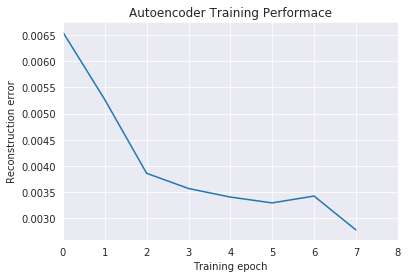

In [0]:
plt.plot(range(0,len(losses)), losses)
plt.xlabel('Training epoch')
plt.xlim([0,len(losses)])
plt.ylabel('Reconstruction error')
plt.title('Autoencoder Training Performace')

Load the pretrained models

In [0]:
encoder_model_name = "ep_8_encoder_model.pth"
decoder_model_name = "ep_8_decoder_model.pth"

encoder_eval = encoder()
decoder_eval = decoder()

encoder_eval.load_state_dict(torch.load(encoder_model_name))
decoder_eval.load_state_dict(torch.load(decoder_model_name))

<All keys matched successfully>

Convert encoded transactional data to torch variable and reconstruct encoded transactional data

In [0]:
data = autograd.Variable(torch_dataset)

encoder_eval.eval()
decoder_eval.eval()

reconstruction = decoder_eval(encoder_eval(data))

Determine reconstruction loss for all transactions

In [0]:
reconstruction_loss_all = loss_function(reconstruction, data)

now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.item()))

[LOG 20191231-19:47:52] collected reconstruction loss of: 533009/533009 transactions
[LOG 20191231-19:47:52] reconstruction loss: 0.0027732425


Determine reconstruction loss for individual transactions

In [0]:
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

for i in range(0, reconstruction.size()[0]):

  reconstruction_loss_transaction[i] = loss_function(reconstruction[i],data[i]).item()

  if(i % 100000 == 0):
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 20191231-20:08:28] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 20191231-20:08:36] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 20191231-20:08:44] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 20191231-20:08:52] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 20191231-20:09:00] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 20191231-20:09:09] collected individual reconstruction loss of: 500000/533009 transactions


Plot data points with their reconstruction losses

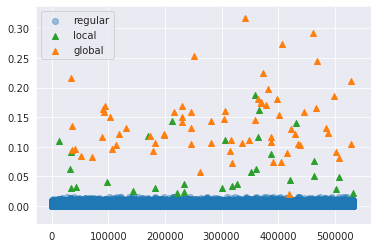

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)

plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

regular_data = plot_data[label == 'regular']
local_outliers = plot_data[label == 'local']
global_outliers = plot_data[label == 'global']

ax.scatter(regular_data[:,0], regular_data[:,1], c='C0', alpha=0.4, marker='o', label='regular')
ax.scatter(local_outliers[:,0], local_outliers[:,1], c='C2', marker='^', label='local')
ax.scatter(global_outliers[:,0], global_outliers[:,1], c='C1', marker='^', label='global')

ax.legend(loc='best')

Finally, we look at the number of local and global anomalies detected

In [0]:
ori_dataset['label'] = label
ori_dataset[reconstruction_loss_transaction >= 0.1].label.value_counts()

global    55
local      8
Name: label, dtype: int64

In [0]:
ori_dataset[(reconstruction_loss_transaction >= 0.018) & (reconstruction_loss_transaction < 0.05)].label.value_counts()

local     15
global     1
Name: label, dtype: int64

We identified 80% (56/70) of the global anomalies and 77% (23/30) of the local anomalies which is excellent when you keep in mind that outliers were only 0.018% of the whole dataset.